You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from Spike_Generation import NL

importing Jupyter notebook from Spike_Generation.ipynb


# Load Experimental data

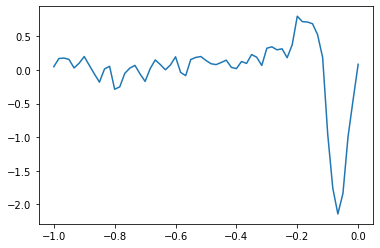

In [3]:
annots = loadmat('D:\\GoogleDrive\\retina\\Chou\'s data\\20210331\\merge\\merge_0224_cSTA_wf_3min_Q100' 
                 , squeeze_me = True)
x = annots['bin_pos']
x = x-np.mean(x)
dt = 1/60
rstate, _ = np.histogram(annots['reconstruct_spikes'][21-1], np.arange(len(x)+1)*dt)

cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
plt.plot(taxis, cSTA)

In [4]:
taxis[np.argmin(cSTA)]

-0.06666666666666667

In [5]:
def NGDcSTA(x, alpha, beta, Kg, tau_y, Amp):
    dt = 1/60
    stimulus = x.copy()
    T = np.arange(0,int(tau_y/dt*8))*dt
    Ky = T/tau_y /tau_y *np.exp(-T/tau_y)
    sstm = np.zeros_like(stimulus)
    for i in range(len(Ky)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*Ky[i-ii]*dt
        sx = np.convolve(stimulus,Ky,'valid')*dt
        sstm[len(Ky)-1:] = sx.copy()

    y=np.zeros_like(sstm)
    z=np.zeros_like(sstm)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+(sstm[j]-z[j]))
        dz=dt*(-beta*z[j]+Kg*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz

    fcSTA = np.correlate(x , NL(-y,0), 'same')/ np.correlate(np.ones_like(x ), NL(-y,0), 'same')
    fcSTA = fcSTA[int(len(fcSTA)/2):int(len(fcSTA)/2-1/dt)-1:-1]
    return  Amp*fcSTA

[4.57768288e+01 1.20334459e+00 1.26653773e+03 7.70558584e-02
 1.18347513e+00]


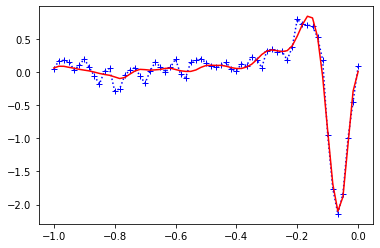

In [9]:
alpha = 41. #1/sec
beta =  2
Kg = 900
tau_y = 0.03
Amp = 1
popt,pcov = curve_fit(NGDcSTA, x, cSTA, p0=[alpha, beta, Kg, tau_y,Amp])
print(popt)
plt.plot(taxis, cSTA, 'b+:', label='data')
plt.plot(taxis, NGDcSTA(x, *popt), 'r-', label='fit')

In [10]:
name_list = ['alpha', 'beta', 'Kg', 'tau_y', 'Amp']
para_dict = {}
for l in range(len(popt)):
    para_dict[name_list[l]] = popt[l]

In [11]:
para_dict

{'alpha': 45.77682881376091,
 'beta': 1.203344585556959,
 'Kg': 1266.5377344374929,
 'tau_y': 0.07705585837703723,
 'Amp': 1.1834751343203247}